# Import libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [16]:
import numpy as np
import pandas as pd

# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load the prepared dataset
from numpy import load
from matplotlib import pyplot as plt

from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

from keras.models import load_model

In [5]:
cd '/content/drive/MyDrive/maps'

/content/drive/MyDrive/maps


# Functions

In [6]:
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	for filename in listdir(path):
		pixels = load_img(path + filename, target_size=size)
		pixels = img_to_array(pixels)
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

In [8]:
def define_discriminator(image_shape):

	init = RandomNormal(stddev=0.02)
 
	in_src_image = Input(shape=image_shape)
	in_target_image = Input(shape=image_shape)
 
	merged = Concatenate()([in_src_image, in_target_image])
 
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
 

	model = Model([in_src_image, in_target_image], patch_out)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
 
	return model

In [9]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):

	init = RandomNormal(stddev=0.02)
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	g = BatchNormalization()(g, training=True)
	if dropout:
		g = Dropout(0.5)(g, training=True)
	g = Concatenate()([g, skip_in])
	g = Activation('relu')(g)
	return g
 
def define_generator(image_shape=(256,256,3)):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)
 
	# encoder
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
 
	# bottleneck
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
 
	# decoder
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
 
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
 
	model = Model(in_image, out_image)
	return model

In [10]:
def define_gan(g_model, d_model, image_shape):
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	in_src = Input(shape=image_shape)
	gen_out = g_model(in_src)
	dis_out = d_model([in_src, gen_out])

	model = Model(in_src, [dis_out, gen_out])
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
 
	return model

In [11]:
def load_real_samples(filename):
	data = load(filename)
	X1, X2 = data['arr_0'], data['arr_1']
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [12]:
def generate_real_samples(dataset, n_samples, patch_shape):
	trainA, trainB = dataset
	ix = randint(0, trainA.shape[0], n_samples)
	X1, X2 = trainA[ix], trainB[ix]
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [13]:
def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [14]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	
	# plot real source
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	
	# plot generated target
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	
	# plot real target
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	
	# save plot
	filename1 = 'img/plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
 
	# save generator
	filename2 = 'models/model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [15]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	n_patch = d_model.output_shape[1]
	trainA, trainB = dataset
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs

	for i in range(n_steps):
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

# Dataset

In [ ]:
train_path = 'data/train/train/'
[src_images, tar_images] = load_images(train_path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  maps_256.npz


In [ ]:
val_path = 'data/val/val/'
[src_images, tar_images] = load_images(val_path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256_val.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1098, 256, 256, 3) (1098, 256, 256, 3)
Saved dataset:  maps_256_val.npz


In [88]:
train_data = load('maps_256.npz')
val_data = load('maps_256_val.npz')

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


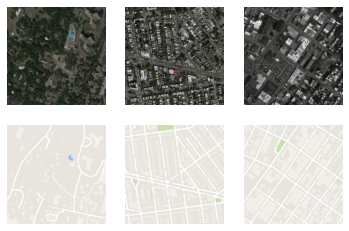

In [ ]:
src_images, tar_images = train_data['arr_0'], train_data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)

n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(src_images[i].astype('uint8'))

for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(tar_images[i].astype('uint8'))
 
plt.savefig('img/examples_train.png')
plt.show()

Loaded:  (1098, 256, 256, 3) (1098, 256, 256, 3)


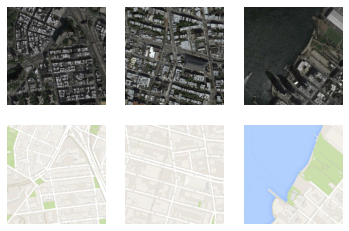

In [ ]:
src_images, tar_images = val_data['arr_0'], val_data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)

n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(src_images[i].astype('uint8'))

for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(tar_images[i].astype('uint8'))
 
plt.savefig('img/examples_val.png')
plt.show()

# Pix2Pix model

In [ ]:
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

# train model
with tf.device('/GPU:0'):
  train(d_model, g_model, gan_model, dataset)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
>5961, d1[0.009] d2[0.169] g[13.616]
>5962, d1[0.041] d2[0.055] g[10.141]
>5963, d1[0.034] d2[0.082] g[12.956]
>5964, d1[0.117] d2[0.101] g[10.086]
>5965, d1[0.048] d2[0.103] g[16.201]
>5966, d1[0.271] d2[0.152] g[14.399]
>5967, d1[0.061] d2[0.624] g[10.446]
>5968, d1[0.042] d2[0.072] g[10.925]
>5969, d1[0.269] d2[0.127] g[6.002]
>5970, d1[0.374] d2[0.083] g[10.074]
>5971, d1[0.120] d2[0.363] g[9.290]
>5972, d1[0.011] d2[0.052] g[11.404]
>5973, d1[0.135] d2[0.116] g[11.879]
>5974, d1[0.008] d2[0.050] g[4.858]
>5975, d1[0.054] d2[0.110] g[10.445]
>5976, d1[0.154] d2[0.065] g[10.307]
>5977, d1[0.007] d2[0.198] g[12.372]
>5978, d1[0.049] d2[0.201] g[8.569]
>5979, d1[0.023] d2[0.081] g[14.061]
>5980, d1[0.238] d2[0.058] g[14.560]
>5981, d1[0.339] d2[0.167] g[7.790]
>5982, d1[0.046] d2[0.184] g[8.626]
>5983, d1[0.009] d2[0.114] g[7.062]
>5984, d1[0.185] d2[0.147] g[8.209]
>5985, d1[0.066] d2[0.158] g[8.124]
>5986, d1[0.108] d2[0.056] g[8.40

Streaming output truncated to the last 5000 lines.
>16921, d1[0.581] d2[0.255] g[5.922]
>16922, d1[0.480] d2[0.235] g[6.672]
>16923, d1[0.149] d2[0.332] g[7.204]
>16924, d1[0.093] d2[0.238] g[7.034]
>16925, d1[0.135] d2[0.086] g[4.889]
>16926, d1[0.211] d2[0.170] g[7.734]
>16927, d1[0.110] d2[0.271] g[7.272]
>16928, d1[0.032] d2[0.140] g[7.608]
>16929, d1[0.401] d2[0.270] g[6.341]
>16930, d1[0.113] d2[0.158] g[7.111]
>16931, d1[0.080] d2[0.297] g[6.852]
>16932, d1[0.113] d2[0.151] g[6.998]
>16933, d1[0.055] d2[0.123] g[7.924]
>16934, d1[0.364] d2[0.510] g[7.382]
>16935, d1[0.227] d2[0.140] g[7.293]
>16936, d1[0.233] d2[0.162] g[7.240]
>16937, d1[0.131] d2[0.295] g[6.774]
>16938, d1[0.026] d2[0.232] g[16.896]
>16939, d1[0.525] d2[0.187] g[6.648]
>16940, d1[0.041] d2[0.096] g[3.106]
>16941, d1[0.103] d2[0.382] g[8.459]
>16942, d1[0.280] d2[0.135] g[4.107]
>16943, d1[0.224] d2[0.426] g[5.357]
>16944, d1[0.272] d2[0.211] g[9.005]
>16945, d1[0.096] d2[0.233] g[8.310]
>16946, d1[0.444] d2[0.

Streaming output truncated to the last 5000 lines.
>27881, d1[0.118] d2[0.190] g[5.838]
>27882, d1[0.153] d2[0.327] g[4.629]
>27883, d1[0.572] d2[0.172] g[5.821]
>27884, d1[0.583] d2[0.228] g[4.812]
>27885, d1[0.155] d2[0.301] g[5.674]
>27886, d1[0.092] d2[0.229] g[6.332]
>27887, d1[0.605] d2[0.190] g[3.671]
>27888, d1[0.106] d2[0.198] g[5.802]
>27889, d1[0.155] d2[0.190] g[7.164]
>27890, d1[0.376] d2[0.261] g[5.511]
>27891, d1[0.093] d2[0.521] g[7.836]
>27892, d1[0.238] d2[0.211] g[5.953]
>27893, d1[0.315] d2[0.209] g[5.038]
>27894, d1[0.109] d2[0.239] g[5.021]
>27895, d1[0.092] d2[0.214] g[8.928]
>27896, d1[0.122] d2[0.200] g[6.330]
>27897, d1[0.093] d2[0.728] g[3.693]
>27898, d1[0.294] d2[0.212] g[3.400]
>27899, d1[0.266] d2[0.242] g[5.305]
>27900, d1[0.179] d2[0.194] g[5.041]
>27901, d1[0.455] d2[0.377] g[4.425]
>27902, d1[0.348] d2[0.482] g[5.063]
>27903, d1[0.157] d2[0.291] g[5.488]
>27904, d1[0.262] d2[0.181] g[5.359]
>27905, d1[0.095] d2[0.273] g[6.223]
>27906, d1[0.146] d2[0.1

Streaming output truncated to the last 5000 lines.
>38841, d1[0.229] d2[0.412] g[5.645]
>38842, d1[0.296] d2[0.333] g[6.063]
>38843, d1[0.484] d2[0.213] g[5.933]
>38844, d1[0.425] d2[0.241] g[4.811]
>38845, d1[0.306] d2[0.435] g[4.682]
>38846, d1[0.183] d2[0.412] g[6.080]
>38847, d1[0.387] d2[0.222] g[2.935]
>38848, d1[0.366] d2[0.332] g[4.951]
>38849, d1[0.238] d2[0.358] g[3.244]
>38850, d1[0.276] d2[0.324] g[3.750]
>38851, d1[0.214] d2[0.208] g[5.306]
>38852, d1[0.193] d2[0.303] g[4.923]
>38853, d1[0.174] d2[0.253] g[6.775]
>38854, d1[0.235] d2[0.396] g[4.974]
>38855, d1[0.335] d2[0.378] g[2.156]
>38856, d1[0.325] d2[0.334] g[5.527]
>38857, d1[0.224] d2[0.241] g[5.530]
>38858, d1[0.219] d2[0.525] g[5.442]
>38859, d1[0.327] d2[0.302] g[3.936]
>38860, d1[0.417] d2[0.297] g[4.396]
>38861, d1[0.255] d2[0.321] g[6.687]
>38862, d1[0.197] d2[0.285] g[3.578]
>38863, d1[0.438] d2[0.294] g[4.701]
>38864, d1[0.329] d2[0.293] g[4.472]
>38865, d1[0.222] d2[0.411] g[6.667]
>38866, d1[0.424] d2[0.3

Streaming output truncated to the last 5000 lines.
>49801, d1[0.449] d2[0.228] g[3.991]
>49802, d1[0.130] d2[0.287] g[4.149]
>49803, d1[0.173] d2[0.313] g[5.520]
>49804, d1[0.309] d2[0.328] g[4.557]
>49805, d1[0.276] d2[0.594] g[5.010]
>49806, d1[0.455] d2[0.255] g[4.112]
>49807, d1[0.232] d2[0.286] g[5.354]
>49808, d1[0.524] d2[0.264] g[3.960]
>49809, d1[0.363] d2[0.285] g[4.880]
>49810, d1[0.366] d2[0.396] g[3.621]
>49811, d1[0.336] d2[0.310] g[4.052]
>49812, d1[0.489] d2[0.251] g[2.218]
>49813, d1[0.158] d2[0.426] g[5.524]
>49814, d1[0.459] d2[0.279] g[3.731]
>49815, d1[0.438] d2[0.335] g[4.232]
>49816, d1[0.334] d2[0.359] g[4.195]
>49817, d1[0.297] d2[0.235] g[4.594]
>49818, d1[0.318] d2[0.316] g[4.016]
>49819, d1[0.214] d2[0.356] g[4.322]
>49820, d1[0.110] d2[0.522] g[5.092]
>49821, d1[0.333] d2[0.256] g[3.244]
>49822, d1[0.364] d2[0.303] g[4.264]
>49823, d1[0.139] d2[0.270] g[4.390]
>49824, d1[0.235] d2[0.383] g[4.836]
>49825, d1[0.366] d2[0.325] g[3.952]
>49826, d1[0.168] d2[0.3

Streaming output truncated to the last 5000 lines.
>60761, d1[0.370] d2[0.298] g[4.374]
>60762, d1[0.296] d2[0.370] g[4.787]
>60763, d1[0.333] d2[0.305] g[4.526]
>60764, d1[0.270] d2[0.301] g[4.269]
>60765, d1[0.367] d2[0.360] g[4.124]
>60766, d1[0.348] d2[0.333] g[4.061]
>60767, d1[0.263] d2[0.374] g[4.224]
>60768, d1[0.435] d2[0.291] g[1.439]
>60769, d1[0.430] d2[0.285] g[2.598]
>60770, d1[0.428] d2[0.253] g[3.721]
>60771, d1[0.353] d2[0.395] g[2.470]
>60772, d1[0.248] d2[0.462] g[4.278]
>60773, d1[0.300] d2[0.320] g[3.408]
>60774, d1[0.414] d2[0.266] g[3.484]
>60775, d1[0.273] d2[0.429] g[3.903]
>60776, d1[0.308] d2[0.404] g[4.043]
>60777, d1[0.287] d2[0.329] g[3.273]
>60778, d1[0.413] d2[0.255] g[2.584]
>60779, d1[0.219] d2[0.537] g[6.020]
>60780, d1[0.197] d2[0.533] g[4.519]
>60781, d1[0.346] d2[0.323] g[4.279]
>60782, d1[0.351] d2[0.320] g[4.236]
>60783, d1[0.354] d2[0.347] g[3.869]
>60784, d1[0.206] d2[0.214] g[4.097]
>60785, d1[0.349] d2[0.331] g[4.145]
>60786, d1[0.317] d2[0.3

Streaming output truncated to the last 5000 lines.
>71721, d1[0.307] d2[0.336] g[3.737]
>71722, d1[0.434] d2[0.258] g[2.530]
>71723, d1[0.430] d2[0.266] g[3.143]
>71724, d1[0.254] d2[0.368] g[3.294]
>71725, d1[0.159] d2[0.441] g[3.595]
>71726, d1[0.295] d2[0.346] g[3.972]
>71727, d1[0.438] d2[0.271] g[1.793]
>71728, d1[0.395] d2[0.274] g[3.863]
>71729, d1[0.245] d2[0.380] g[4.197]
>71730, d1[0.185] d2[0.560] g[4.717]
>71731, d1[0.438] d2[0.254] g[3.502]
>71732, d1[0.290] d2[0.440] g[4.178]
>71733, d1[0.330] d2[0.280] g[4.051]
>71734, d1[0.359] d2[0.310] g[4.111]
>71735, d1[0.289] d2[0.440] g[3.530]
>71736, d1[0.295] d2[0.329] g[4.595]
>71737, d1[0.186] d2[0.440] g[3.919]
>71738, d1[0.441] d2[0.237] g[4.010]
>71739, d1[0.343] d2[0.306] g[3.870]
>71740, d1[0.329] d2[0.385] g[3.451]
>71741, d1[0.175] d2[0.482] g[4.434]
>71742, d1[0.264] d2[0.318] g[4.907]
>71743, d1[0.438] d2[0.238] g[3.797]
>71744, d1[0.385] d2[0.304] g[4.098]
>71745, d1[0.360] d2[0.336] g[3.234]
>71746, d1[0.315] d2[0.3

Streaming output truncated to the last 5000 lines.
>82681, d1[0.294] d2[0.376] g[3.588]
>82682, d1[0.290] d2[0.348] g[3.928]
>82683, d1[0.346] d2[0.322] g[4.197]
>82684, d1[0.382] d2[0.397] g[3.097]
>82685, d1[0.312] d2[0.364] g[1.882]
>82686, d1[0.302] d2[0.329] g[4.329]
>82687, d1[0.399] d2[0.274] g[3.589]
>82688, d1[0.196] d2[0.278] g[3.627]
>82689, d1[0.219] d2[0.509] g[3.623]
>82690, d1[0.332] d2[0.287] g[3.168]
>82691, d1[0.270] d2[0.390] g[3.495]
>82692, d1[0.222] d2[0.468] g[4.397]
>82693, d1[0.322] d2[0.353] g[4.015]
>82694, d1[0.436] d2[0.288] g[2.849]
>82695, d1[0.348] d2[0.331] g[3.605]
>82696, d1[0.408] d2[0.300] g[3.367]
>82697, d1[0.352] d2[0.339] g[3.809]
>82698, d1[0.331] d2[0.365] g[3.573]
>82699, d1[0.246] d2[0.451] g[4.253]
>82700, d1[0.253] d2[0.385] g[4.761]
>82701, d1[0.378] d2[0.279] g[3.727]
>82702, d1[0.399] d2[0.324] g[1.161]
>82703, d1[0.394] d2[0.286] g[3.310]
>82704, d1[0.378] d2[0.338] g[1.352]
>82705, d1[0.404] d2[0.309] g[3.382]
>82706, d1[0.291] d2[0.3

Streaming output truncated to the last 5000 lines.
>93641, d1[0.355] d2[0.325] g[3.693]
>93642, d1[0.425] d2[0.302] g[1.581]
>93643, d1[0.316] d2[0.351] g[3.710]
>93644, d1[0.239] d2[0.371] g[4.017]
>93645, d1[0.421] d2[0.297] g[2.028]
>93646, d1[0.414] d2[0.299] g[3.807]
>93647, d1[0.342] d2[0.315] g[3.734]
>93648, d1[0.423] d2[0.270] g[2.986]
>93649, d1[0.226] d2[0.301] g[3.861]
>93650, d1[0.379] d2[0.325] g[2.972]
>93651, d1[0.283] d2[0.414] g[1.938]
>93652, d1[0.204] d2[0.414] g[6.447]
>93653, d1[0.394] d2[0.291] g[2.029]
>93654, d1[0.288] d2[0.369] g[4.207]
>93655, d1[0.317] d2[0.361] g[3.846]
>93656, d1[0.342] d2[0.337] g[3.386]
>93657, d1[0.290] d2[0.351] g[3.516]
>93658, d1[0.435] d2[0.295] g[2.730]
>93659, d1[0.242] d2[0.356] g[4.839]
>93660, d1[0.357] d2[0.358] g[2.965]
>93661, d1[0.414] d2[0.317] g[1.764]
>93662, d1[0.310] d2[0.296] g[4.464]
>93663, d1[0.438] d2[0.324] g[3.359]
>93664, d1[0.376] d2[0.322] g[3.134]
>93665, d1[0.335] d2[0.364] g[3.205]
>93666, d1[0.359] d2[0.3

Streaming output truncated to the last 5000 lines.
>104601, d1[0.495] d2[0.278] g[2.816]
>104602, d1[0.299] d2[0.364] g[3.930]
>104603, d1[0.375] d2[0.322] g[3.226]
>104604, d1[0.351] d2[0.302] g[3.438]
>104605, d1[0.288] d2[0.492] g[1.749]
>104606, d1[0.305] d2[0.392] g[4.144]
>104607, d1[0.261] d2[0.471] g[1.290]
>104608, d1[0.288] d2[0.414] g[1.775]
>104609, d1[0.384] d2[0.343] g[3.494]
>104610, d1[0.333] d2[0.302] g[3.823]
>104611, d1[0.329] d2[0.304] g[4.935]
>104612, d1[0.431] d2[0.257] g[4.259]
>104613, d1[0.436] d2[0.276] g[3.198]
>104614, d1[0.296] d2[0.339] g[4.229]
>104615, d1[0.364] d2[0.454] g[1.789]
>104616, d1[0.413] d2[0.457] g[2.575]
>104617, d1[0.289] d2[0.427] g[4.158]
>104618, d1[0.267] d2[0.430] g[4.261]
>104619, d1[0.293] d2[0.387] g[3.484]
>104620, d1[0.308] d2[0.362] g[3.825]
>104621, d1[0.352] d2[0.376] g[3.237]
>104622, d1[0.384] d2[0.325] g[2.767]
>104623, d1[0.324] d2[0.343] g[3.402]
>104624, d1[0.369] d2[0.299] g[3.869]
>104625, d1[0.336] d2[0.304] g[3.965]

>Saved: img/plot_109600.png and models/model_109600.h5


# Evaluation

In [99]:
model = load_model('models/model_109600.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 64  3136        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 128, 128, 64  0           ['conv2d_6[0][0]']               
                                )                                                           

In [100]:
def plot_images(src_img, gen_img, tar_img, index):
  images = vstack((src_img, gen_img, tar_img))
  images = (images + 1) / 2.0
  titles = ['Source', 'Generated', 'Expected']

  for i in range(len(images)):
    plt.subplot(1, 3, 1 + i)
    plt.axis('off')
    plt.imshow(images[i])
    plt.title(titles[i])

  plt.savefig(f'img/eval/{index}.png')
  if index % 100 == 0:
    plt.show()

In [101]:
[X1, X2] = load_real_samples('maps_256_val.npz')
print('Loaded', X1.shape, X2.shape)

Loaded (1098, 256, 256, 3) (1098, 256, 256, 3)


In [110]:
def plot_gen_img(gen_img, index):
  gen_img = (gen_img + 1) / 2.0
  plt.imshow(gen_img[0])
  plt.gca().set_axis_off()
  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
  plt.margins(0,0)
  plt.gca().xaxis.set_major_locator(plt.NullLocator())
  plt.gca().yaxis.set_major_locator(plt.NullLocator())
  plt.axis('off')
  plt.savefig(f'img/eval/gen/gen_{index}.png', bbox_inches = 'tight',
    pad_inches = 0)
  # plt.show()

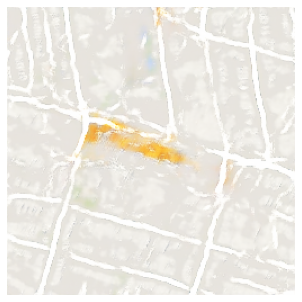

In [111]:
for i in range(300):
  src_img, target_img = X1[[i]], X2[[i]]
  generated = model.predict(src_img)
  plot_gen_img(generated, i)

## Inception score

In [112]:
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.datasets.mnist import load_data
from skimage.transform import resize

In [113]:
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		new_image = resize(image, new_shape, 0)
		images_list.append(new_image)
	return asarray(images_list)

In [114]:
def calculate_inception_score(images, n_split=10, eps=1E-16):
  model = InceptionV3()
  processed = images.astype('float32')
  processed = scale_images(processed, (299, 299, 3))
  processed = preprocess_input(processed)
  yhat = model.predict(processed)
  scores = list()
  n_part = floor(images.shape[0] / n_split)

  for i in range(n_split):
    ix_start, ix_end = i * n_part, i * n_part + n_part
    p_yx = yhat[ix_start:ix_end]
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    sum_kl_d = kl_d.sum(axis=1)
    avg_kl_d = mean(sum_kl_d)
    is_score = exp(avg_kl_d)
    scores.append(is_score)

  is_avg, is_std = mean(scores), std(scores)
  return is_avg, is_std

In [115]:
gen_img_dir = 'img/eval/gen/'
gen_img = load_images(gen_img_dir)
filename = 'gen_256.npz'
savez_compressed(filename, gen_img)
print('Saved dataset: ', filename)

Saved dataset:  gen_256.npz


In [116]:
gen_data = load('gen_256.npz')
gen_img, _ = gen_data['arr_0']
gen_img.shape

(300, 256, 256, 3)

In [117]:
is_avg, is_std = calculate_inception_score(gen_img)
print('score', is_avg, is_std)

score 3.184915 0.28328788


## Frechet Inception Distance

In [118]:
def calculate_fid(model, images1, images2):
	act1 = model.predict(images1)
	act2 = model.predict(images2)

	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)

	ssdiff = numpy.sum((mu1 - mu2)**2.0)

	covmean = sqrtm(sigma1.dot(sigma2))

	if iscomplexobj(covmean):
		covmean = covmean.real

	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

(300, 256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

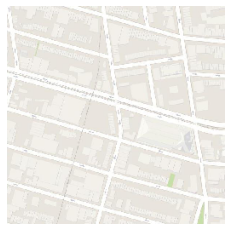

In [119]:
_, tar_images = val_data['arr_0'], val_data['arr_1']
tar_img = tar_images[:300]
print(tar_img.shape)

plt.imshow(tar_img[1].astype('uint8'))
plt.axis('off')

In [120]:
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299,3))

print('Prepared', gen_img.shape, tar_img.shape)

Prepared (300, 256, 256, 3) (300, 256, 256, 3)


In [121]:
images1 = gen_img.astype('float32')
images2 = tar_img.astype('float32')

images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)

images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)

fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

Scaled (300, 299, 299, 3) (300, 299, 299, 3)
FID (same): -0.000
FID (different): 245.103
